# 虚拟培养皿：生长、代谢物和通量的空间模拟和分析

In [1]:
import cobra
import cobra.io # for the e coli core model
import sys
import numpy as np
#sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/cometspy") # not necessary if you pip install cometspy
import cometspy as c
from matplotlib import pyplot as plt


我们将使用大肠杆菌核心模型（ E. coli core），该模型可在cobrapy中获取。

In [2]:
core = cobra.io.load_model('textbook')

我们将核心（core）模型转化为COMETS模型，打开其下限交换边界（使得边界值由环境决定），并设置对流参数以模拟菌落的推挤扩展过程。同时，我们还会选定若干位置投放起始生物量。

In [3]:
ecoli = c.model(core)
ecoli.open_exchanges()
ecoli.add_convection_parameters(packedDensity = 0.022,
                                    elasticModulus = 1.e-10,
                                    frictionConstant = 1.0,
                                    convDiffConstant = 0.0)
ecoli.add_noise_variance_parameter(100.)

# ecoli.initial_pop = [[x, x, 1.e-6] for x in [10,20,30,40]]

ecoli.initial_pop = [[140, 50, 1.e-6],
                    [58, 162, 1.e-6],
                    [28,55,1.e-6],
                    [132, 78, 1.e-6],
                    [85, 152, 1.e-6],
                    [73, 123, 1.e-6],
                    [34, 76, 1.e-6],
                    [150, 45, 1.e-6],
                     [120, 73, 1.e-6],
                     [34, 138, 1.e-6],
                     [44, 180, 1.e-6],
                     [180, 150, 1.e-6],
                     [165, 135, 1.e-6],
                     [24, 38, 1.e-6],
                     [44, 45, 1.e-6],
                     [99, 108, 1.e-6],
                     [95, 23, 1.e-6],
                     [35, 101, 1.e-6],
                     [25, 102, 1.e-6]]

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:623: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.smat = pd.concat([self.smat, cdf])
C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:636: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


本协议新颖之处在于，“培养皿”被划分为两个不同的空间区域，每个区域具有不同的代谢物扩散系数。用户必须定义一系列参数来实现这一点：首先是“区域映射”，它是一个二维整数矩阵，对应于特定区域；然后是特定于区域的参数。我们将逐一进行这些操作。

首先，定义区域映射。在这个示例中，我们将使用一个由200x200个小格构成的模拟区域。一半的“培养皿”为一个区域，另一半则为另一个区域。我们将创建一个整数numpy数组来描述这一划分。此外，尽管并非必要，我还会将区域映射绘制成图像进行展示。

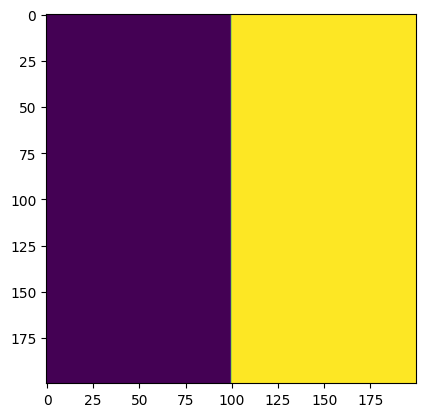

In [4]:
width = 200
grid_size = [width, width] # width boxes in each direction
region_map = np.zeros(grid_size, dtype = int) # an integer array filled with zeros
region_map[:] = 1 # first fill the whole map with 1s
region_map[int(width/2):width,:] = 2 # next fill the bottom half with 2s

# this code here is unnecessary, but useful to visualize your region map:
plt.imshow(np.transpose(region_map))

区域映射（region_map）看起来是正确的：一个200x200的正方形区域被划分为两个区域。接下来，我们将创建模拟的基础布局，并设置这个区域映射。完成这一步后，我们将设置各区域的具体参数。

In [5]:
ly = c.layout([ecoli])
ly.grid = grid_size
ly.set_region_map(region_map)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\layout.py:1361: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.media = pd.concat([self.media, new_row],


特定于区域的参数包括每个代谢物在各区域内的扩散系数，以及每个区域中应用于所有代谢物的一个单一摩擦常数。为了简化处理，我们将在每个区域内对所有代谢物使用相同的扩散系数。其中，第一区域的扩散系数为5e-6（平方厘米/秒），第二区域则为5e-7。两个区域的摩擦常数均为1.0。

因为对每个代谢物我们都采用相同的数值，所以我们只需要创建一个列表，其长度与模拟中代谢物的数量相等。

In [6]:
num_mets = ly.media.shape[0]
diffusion_constant_region1 = [5.e-6] * num_mets
diffusion_constant_region2 = [5.e-7] * num_mets
friction_constant = 1.0

In [7]:
#我们通过指定（整数）区域，然后传递扩散常数和标量摩擦常数的列表来设置这些值。这必须针对每个区域单独执行。

ly.set_region_parameters(1, diffusion_constant_region1, friction_constant)
ly.set_region_parameters(2, diffusion_constant_region2, friction_constant)

培养基浓度最初在“培养皿”中是恒定的。我们将在这里设置这些。

In [8]:
ly.set_specific_metabolite("glc__D_e", 5.e-5)
ly.set_specific_metabolite("h2o_e", 1000.)
ly.set_specific_metabolite("nh4_e", 1000.)
ly.set_specific_metabolite("h_e", 1000.)
ly.set_specific_metabolite("pi_e", 1000.)
ly.display_current_media()

      diff_c g_refresh g_static g_static_val init_amount metabolite
8   0.000005         0        0            0     0.00005   glc__D_e
11  0.000005         0        0            0      1000.0      h2o_e
12  0.000005         0        0            0      1000.0        h_e
15  0.000005         0        0            0      1000.0      nh4_e
17  0.000005         0        0            0      1000.0       pi_e


接下来，我们设置相关参数。我们必须确保将“biomassMotionStyle”设置为“Convection 2D”，否则生物质将不会使用上面设置的对流参数。

In [9]:
p = c.params()

p.all_params["maxCycles"] = 5000
p.all_params["biomassMotionStyle"] = "Convection 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = p.all_params["maxCycles"]
p.all_params["defaultKm"] = 0.01
p.all_params["defaultVmax"] = 10
p.all_params["timeStep"] = 0.01
p.all_params["spaceWidth"] = 0.02
p.all_params["maxSpaceBiomass"] = 10
p.all_params["minSpaceBiomass"] = 1.e-10
p.all_params["allowCellOverlap"] = True
p.all_params["writeFluxLog"] = True
p.all_params["FluxLogRate"] = p.all_params["maxCycles"]
p.all_params["writeMediaLog"] = True
p.all_params["MediaLogRate"] = p.all_params["maxCycles"]

现在我们制作一个模拟对象并运行它。这可能需要一段时间。

In [ ]:
sim = c.comets(ly, p)
sim.run()


Running COMETS simulation ...


接下来，我们依次使用三种不同的辅助函数来获得生物量、代谢物浓度和通量值（生长率，这里），并将它们绘制在二维空间中。

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
import copy
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))
im = sim.get_biomass_image('e_coli_core', p.all_params["maxCycles"])
plt.imshow(im, norm = matplotlib.colors.LogNorm(), cmap = my_cmap)

In [ ]:
# glucose
plt.imshow(sim.get_metabolite_image("glc__D_e", p.all_params['maxCycles']+1))

In [ ]:
# growth rate
im = sim.get_flux_image("e_coli_core", "Biomass_Ecoli_core", p.all_params["maxCycles"])

In [ ]:
plt.imshow(im)